# ASTR 596: FDS Homework 5: Hunting for Exoplanets (Due April 1 at Noon)


### The Kepler satellite has discovered many multi-planet systems. You can download artwork for some of them even at the [Exoplanet Travel Bureau](https://exoplanets.nasa.gov/alien-worlds/exoplanet-travel-bureau/)

<img src="Kepler-186f_small.jpg" width="500">


### But is there a system like our own Solar system with 8 planets (sorry Pluto)? In fact, there may be at least one - [Kepler 90](https://www.nytimes.com/2017/12/14/science/eight-planets-star-system.html). This along with most other Kepler planets, were not discovered through radial velocity measurements like our example in class (i.e. that nice parameteric model doesn't apply), but were rather discovered through transits - dips in the light of the star as the planet moves around it.


<img src="Transiting-Exoplanet-Light-Curve.gif">

### You get to find 3 exoplanets in the Kepler-90 system with the techniques in class. 


### To get and analyze the Kepler data, you'll need the `lightkurve` package

> `python -m pip install lightkurve --upgrade`

### I've included some code to get the light curve, clean it and remove the NaNs, and some outliers (you can judge the wisdom of strong outlier removal when you are hunting for planets), and bin the light curve a little bit in time.


<hr>

#### Hints:


* `lightkurve` has a bunch of useful [tutorials](https://docs.lightkurve.org/index.html), in particular [this one](https://docs.lightkurve.org/tutorials/3-science-examples/periodograms-creating-periodograms.html)

* once you get to a periodogram with `lightkurve`, `find_peaks` in `scipy` can help identify the exoplanet peaks

* You might find it easier to remove the signal of each planet as you find it and work with the residual light curve to find the next. This isn't strictly necessary if you do the previous steps well, but can be helpful. The tutorials page has a demo.

* [The Exoplanet Archive](https://exoplanetarchive.ipac.caltech.edu/index.html) might be of help

<hr>

# Happy (planet) hunting!

In [1]:
%matplotlib notebook
%pylab
import numpy as np
import astropy.table as at
import astropy.units as u
import matplotlib.pyplot as plt
import lightkurve as lk
from scipy.signal import find_peaks, find_peaks_cwt

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
### RUN THIS
lcfs = lk.search_lightcurve('Kepler-90', mission='Kepler').download_all()

In [3]:
### RUN THIS
def squelch_rednoise(lc):
    corrected_lc = lc.remove_outliers(sigma_upper=10, sigma_lower=10).normalize().flatten(window_length=901)
    return corrected_lc

<IPython.core.display.Javascript object>


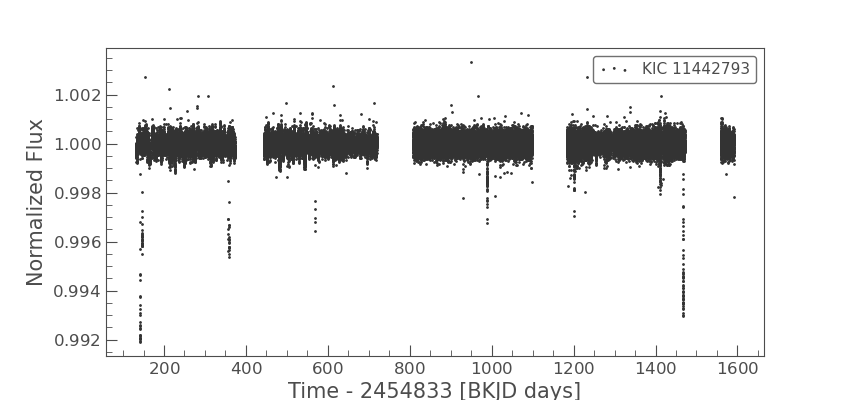

In [4]:
### RUN THIS - it will take a while.
stitched_lc = lcfs.stitch(corrector_func=squelch_rednoise)
clc = stitched_lc.remove_nans().bin(time_bin_size=15*u.min)
clc.scatter();

# This is the data we'll deal with

# Q1. First, calculate the periodogram using lightkurve. Use the `bls` method. Look for planets between 50 and 500 day periods with a grid spacing of 0.01d - this is coarse. Use `scipy.signal.find_peaks` to identify peaks in the periodogram. Remember to exclude any peaks arising from the Earth's revolution. Plot the periodogram and highlight the peak locations. (25 pts)


In [5]:
# YOUR CODE HERE

First, I'll save `clc` so that I can load it quicker in the future.

In [72]:
clc.to_fits('clc.fits', overwrite=True, extra_data = {'time_bin_start','time_bin_size',
                                                      'timecorr','cadenceno','sap_flux',
                                                      'sap_flux_err','sap_bkg','sap_bkg_err',
                                                      'pdcsap_flux','pdcsap_flux_err','psf_centr1',
                                                      'psf_centr1_err','psf_centr2','psf_centr2_err',
                                                      'mom_centr1_err','mom_centr2_err','pos_corr1','pos_corr2'})

In [2]:
clc_read = lk.KeplerLightCurve.read('clc.fits', quality_bitmask='none')

<IPython.core.display.Javascript object>


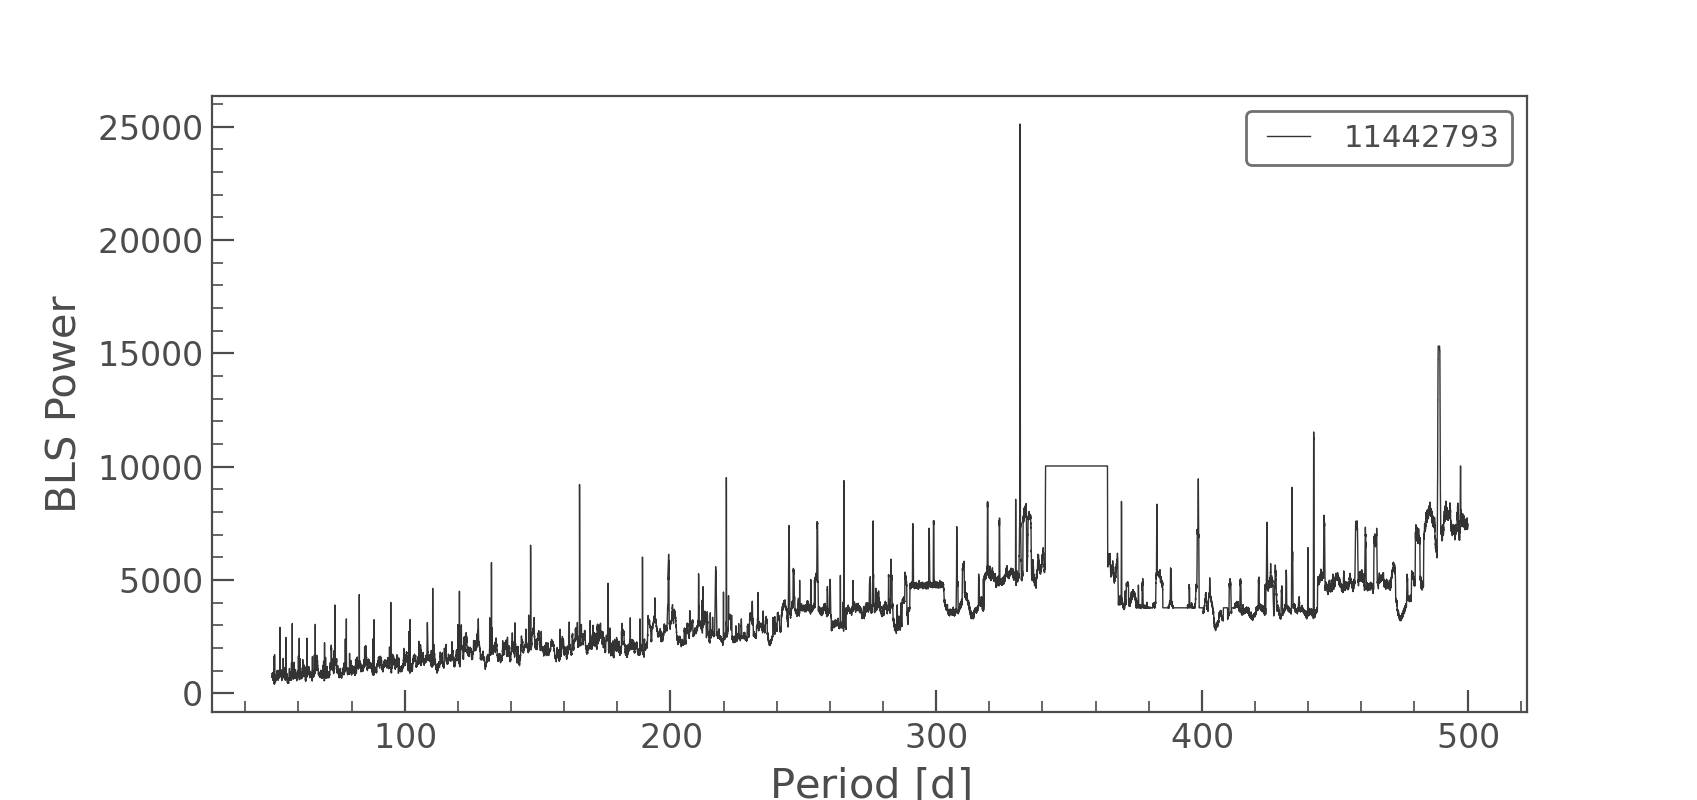

In [3]:
# Define a grid of periods with 0.01 day spacing
n_gridpoints = int((500 - 50)/0.01)
period = np.linspace(50, 500, n_gridpoints)

# calculate the bls (Box Least Squares) periodogram
bls = clc_read.to_periodogram(method='bls', period=period);
bls.plot();

Inspecting the BLS periodogram, there is a wide plateau in power from a period of $\sim$ 340 to 360 days. Given the Earth's 365 day revolution, this plateau likely results from non-uniform sampling, so I'll mask out peaks with periods between 340 and 369 days. Inspecting the typical heights of peaks, I choose to use the parameter `distance=500` in `scipy.signal.find_peaks`

<IPython.core.display.Javascript object>


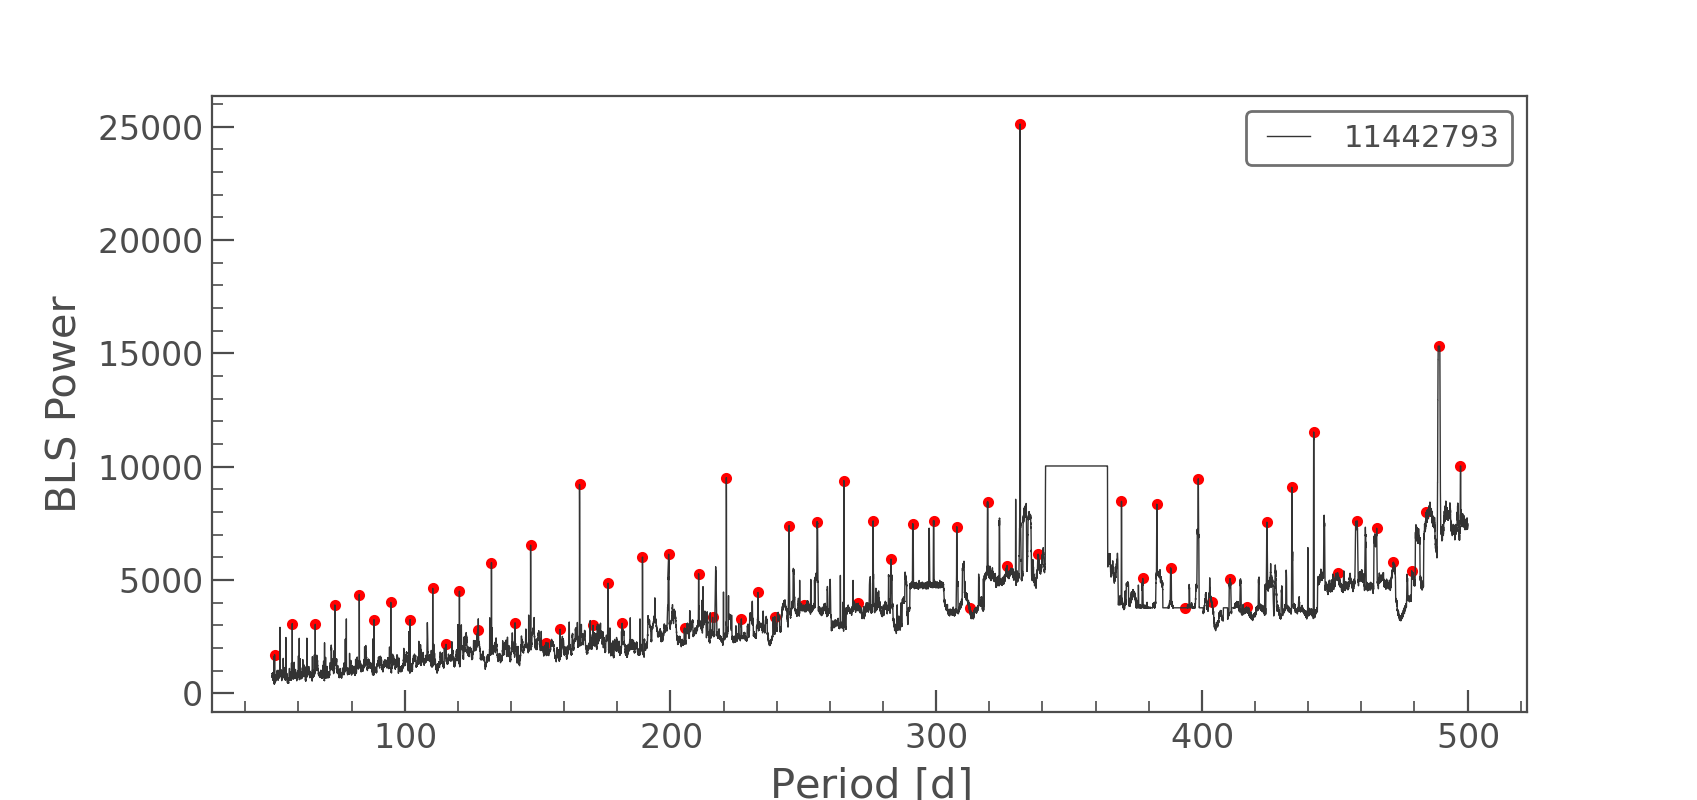

In [4]:
bls.plot();
peak_locations = find_peaks(bls.power, distance=500)[0]
mask_year = (bls.period[peak_locations].value < 340.) | (bls.period[peak_locations].value > 369.)
scatter(bls.period[peak_locations][mask_year], bls.power[peak_locations][mask_year],
       marker='.', color='r');

`find_peaks` with this parameter does a good job of identifying most of the prominent peaks without identifying an overwhelming number of small peaks in the low power regime.

# Q2. a. The periodogram function from lightkurve can also get a transit time and peak power using `periodogram.transit_time` and `periodogram.power` - you'll want both. Get a sorted list of candidate periods, and print it sorted by peak power. (10 pts)

In [5]:
# YOUR CODE HERE

candidate_periods = bls.period[peak_locations][mask_year]
candidate_powers = bls.power[peak_locations][mask_year]

sort_by_power = np.argsort(candidate_powers)[::-1]

print('Candidate periods sorted by decreasing power:')
for candidate_per in candidate_periods[sort_by_power]:
    print(candidate_per)

Candidate periods sorted by decreasing power:
331.5762572501611 d
489.4497655503456 d
442.09871330474016 d
497.34994110980244 d
221.04380097335496 d
398.6777483944088 d
265.254783439632 d
165.78257294606547 d
433.8785306340141 d
369.7571057134603 d
319.34598546634373 d
383.0674014978111 d
484.41965377008376 d
299.0755350118892 d
458.40907575723907 d
276.2850285561901 d
255.23456076801708 d
424.4983221849375 d
291.1753594524323 d
244.67432609613547 d
307.7457276828374 d
465.8092402053379 d
147.36216360363562 d
338.3964088090847 d
199.32331829596214 d
189.47309940220896 d
283.0051778928421 d
472.1193804306763 d
132.63183626302808 d
326.5561456921265 d
388.24751661148025 d
478.97953287850845 d
451.07891286473034 d
210.59356874597214 d
377.7572834951888 d
410.6080135114114 d
176.52281161803597 d
110.52134491877597 d
120.58156847929953 d
232.9140647569946 d
82.89073090513122 d
403.6978599524435 d
94.74099424431654 d
270.65490344229875 d
73.68052623391631 d
250.1744483210738 d
416.8981532922

# Q2. b. Next sort the list of periods from longest to shorted. Check if each period has a period in your list that is either 1/2 or 1/3 the same value. If it is, exclude it. If not keep it. Select the four periods with the highest power between 0 to 100d, 100d and 200d, 200d and 300d and 300d and 400d. (15 pts)

In [6]:
# YOUR CODE HERE
sort_by_period = np.argsort(candidate_periods)[::-1]
reduced_period_list = []
reduced_powers = []
for current_period, current_power in list(zip(candidate_periods[sort_by_period],
                                              candidate_powers[sort_by_period])):
    if (np.min(abs(current_period/2. - candidate_periods)).value > 0.05) and \
                    (np.min(abs(current_period/3. - candidate_periods)).value > 0.05):
        reduced_period_list += [current_period.value]
        reduced_powers += [current_power.value]

In [7]:
print(len(candidate_periods))

65


In [8]:
print(len(reduced_period_list))

50


In [9]:
65-34

31

Turns out there were 50 candidate periods that were multiples of other candidates by factors of 2 or 3. The new candidate list is 31, which I plot against the BLS periodogram below:

<IPython.core.display.Javascript object>


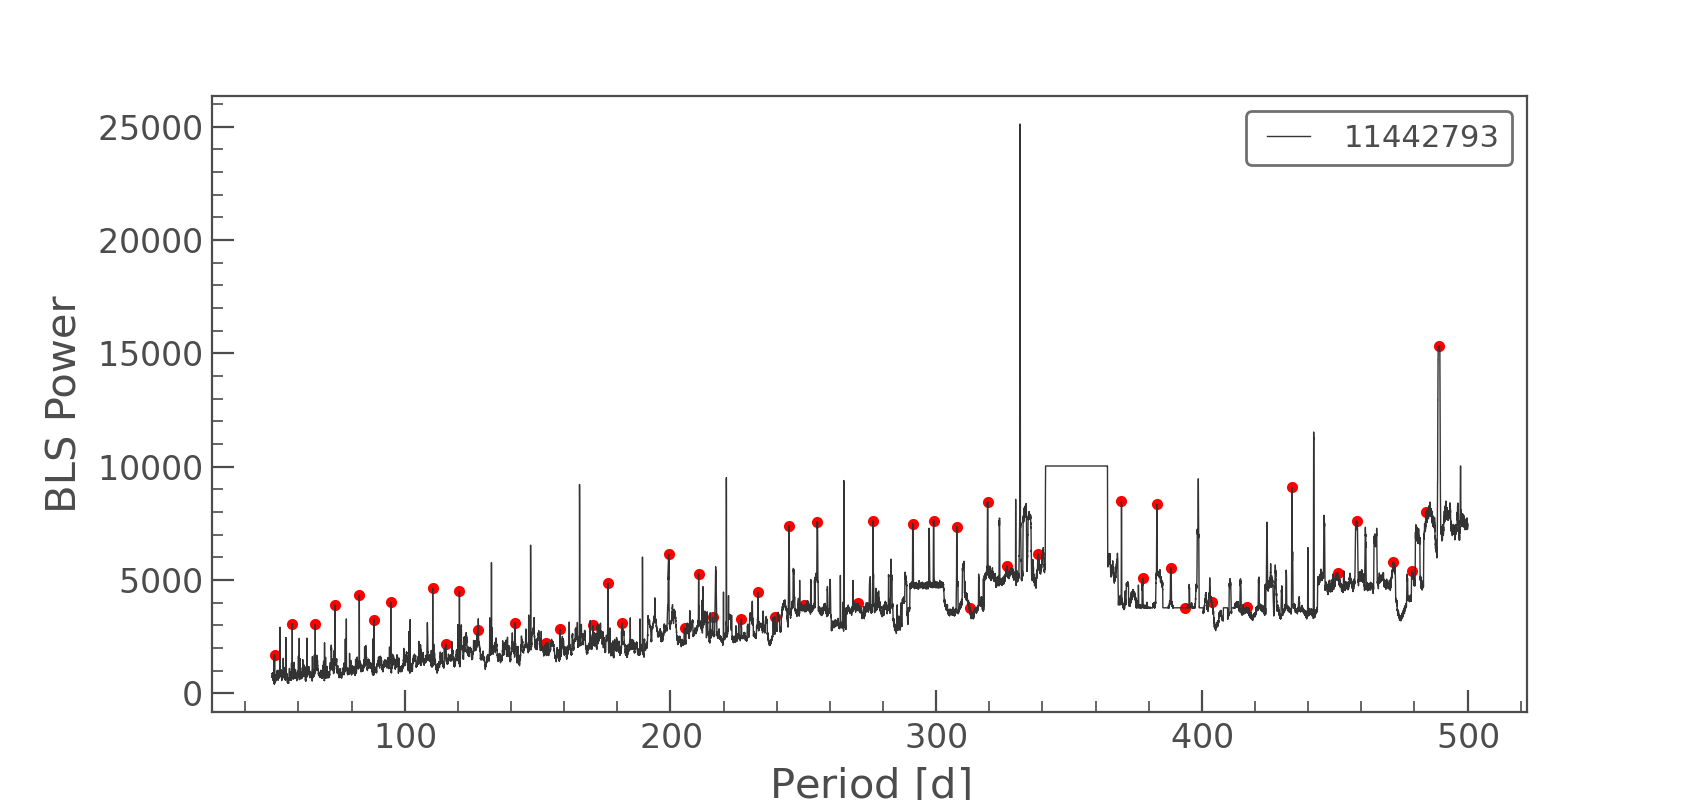

In [10]:
bls.plot();
scatter(reduced_period_list, reduced_powers,
       marker='.', color='r');

Now, I select the four periods with the highest power between 0 to 100d, 100d and 200d, 200d and 300d and 300d and 400d.

In [11]:
index_in_range = np.where(np.array(reduced_period_list) < 100.)
powers_in_range = np.array(reduced_powers)[index_in_range]
max_power_in_range = np.max(powers_in_range)
where_max_power = np.where(powers_in_range == max_power_in_range)
period_at_max1 = np.array(reduced_period_list)[index_in_range[0][where_max_power[0][0]]]
print('max power in range 0 - 100d at ', period_at_max1, 'days')

index_in_range = np.where((np.array(reduced_period_list) >= 100.) &\
                          (np.array(reduced_period_list) < 200.))
powers_in_range = np.array(reduced_powers)[index_in_range]
max_power_in_range = np.max(powers_in_range)
where_max_power = np.where(powers_in_range == max_power_in_range)
period_at_max2 = np.array(reduced_period_list)[index_in_range[0][where_max_power[0][0]]]
print('max power in range 100 - 200d at ', period_at_max2, 'days')

index_in_range = np.where((np.array(reduced_period_list) >= 200.) &\
                          (np.array(reduced_period_list) < 300.))
powers_in_range = np.array(reduced_powers)[index_in_range]
max_power_in_range = np.max(powers_in_range)
where_max_power = np.where(powers_in_range == max_power_in_range)
period_at_max3 = np.array(reduced_period_list)[index_in_range[0][where_max_power[0][0]]]
print('max power in range 200 - 300d at ', period_at_max3, 'days')

index_in_range = np.where((np.array(reduced_period_list) >= 300.) &\
                          (np.array(reduced_period_list) < 400.))
powers_in_range = np.array(reduced_powers)[index_in_range]
max_power_in_range = np.max(powers_in_range)
where_max_power = np.where(powers_in_range == max_power_in_range)
period_at_max4 = np.array(reduced_period_list)[index_in_range[0][where_max_power[0][0]]]
print('max power in range 300 - 400d at ', period_at_max4, 'days')

max power in range 0 - 100d at  82.89073090513122 days
max power in range 100 - 200d at  199.32331829596214 days
max power in range 200 - 300d at  299.0755350118892 days
max power in range 300 - 400d at  369.7571057134603 days


# Q3. Select each peak period from the coarse grid in Q2.b. and then use lightkurve algorithm to refine the period within +/- 5 days, and get the best period. (25 pts)

In [12]:
# YOUR CODE HERE

# Define a grid of periods with 0.0001 day spacing
n_gridpoints_refined = int((10)/0.001)
period_refined1 = np.linspace(period_at_max1-5., period_at_max1+5., n_gridpoints_refined)
period_refined2 = np.linspace(period_at_max2-5., period_at_max2+5., n_gridpoints_refined)
period_refined3 = np.linspace(period_at_max3-5., period_at_max3+5., n_gridpoints_refined)
period_refined4 = np.linspace(period_at_max4-5., period_at_max4+5., n_gridpoints_refined)

# calculate the bls (Box Least Squares) periodogram
bls1 = clc_read.to_periodogram(method='bls', period=period_refined1);
bls2 = clc_read.to_periodogram(method='bls', period=period_refined2);
bls3 = clc_read.to_periodogram(method='bls', period=period_refined3);
bls4 = clc_read.to_periodogram(method='bls', period=period_refined4);

<IPython.core.display.Javascript object>


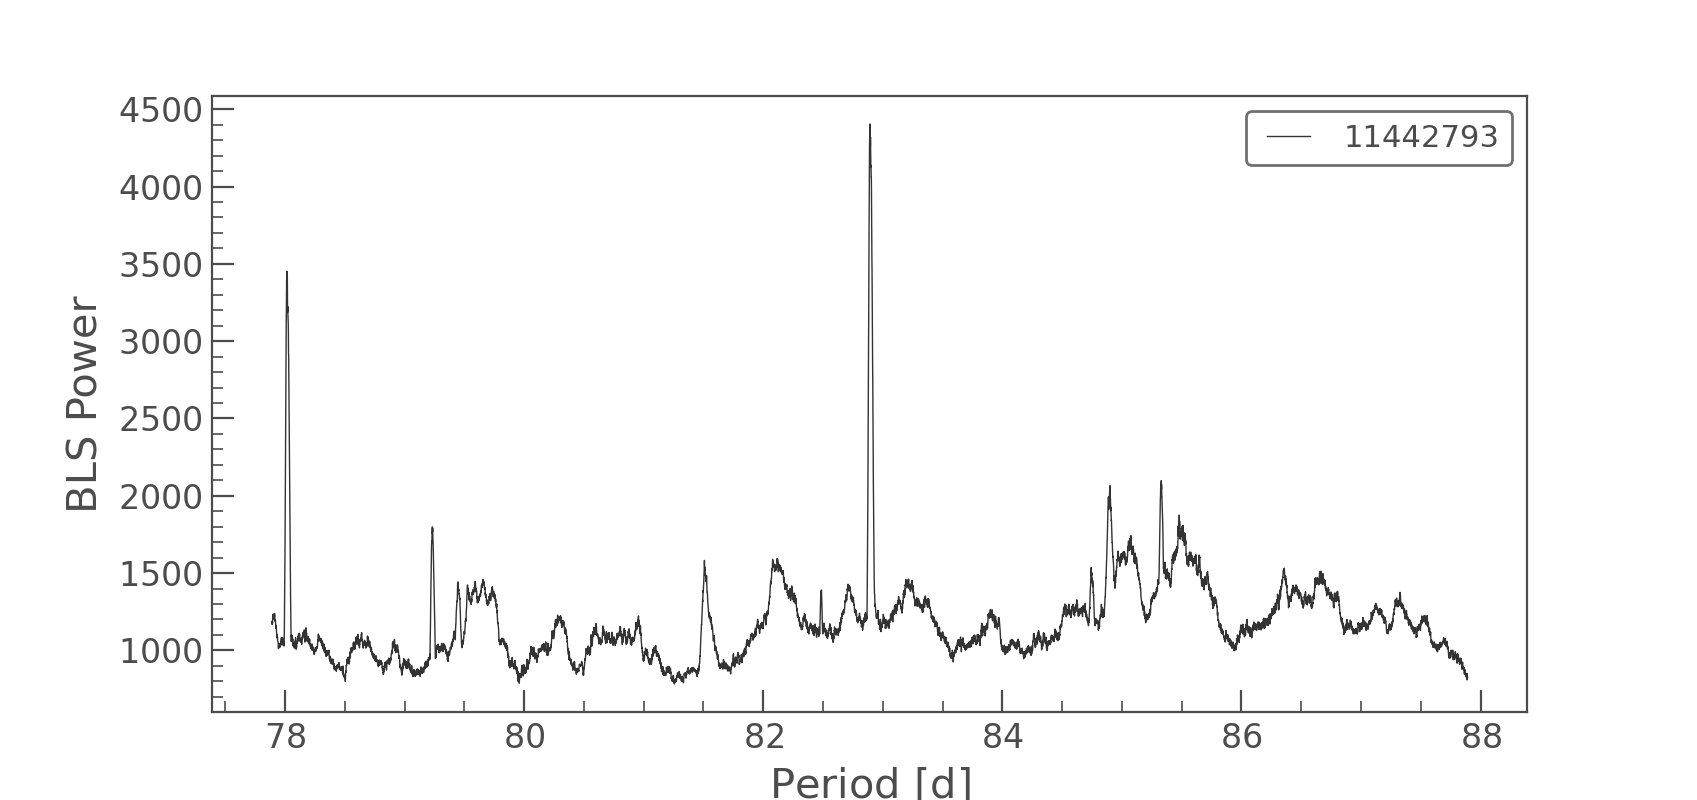

In [17]:
bls1.plot();

<IPython.core.display.Javascript object>


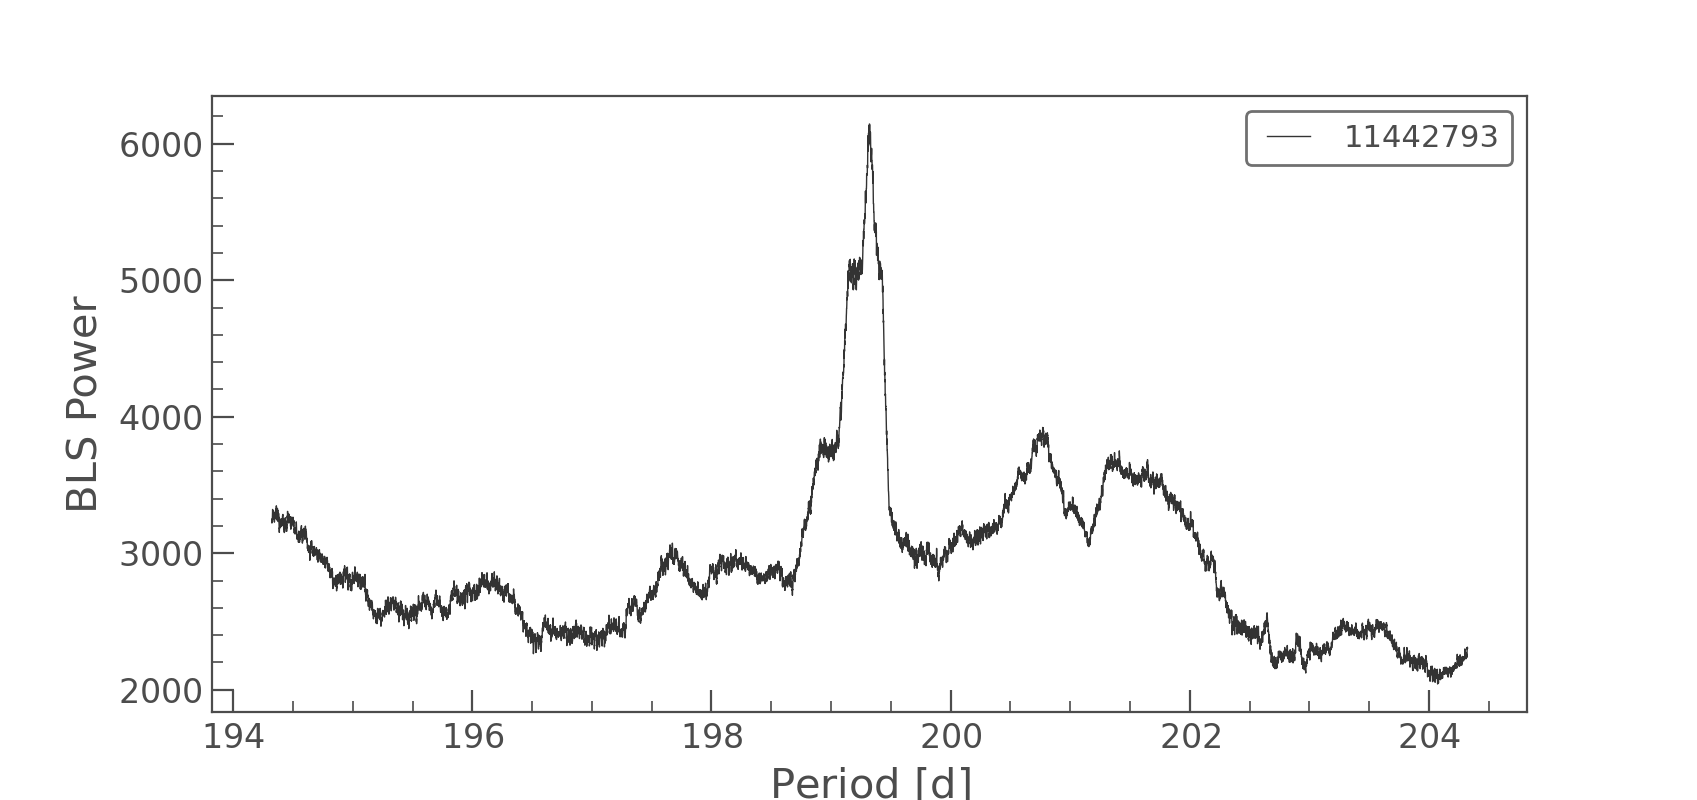

In [18]:
bls2.plot();

<IPython.core.display.Javascript object>


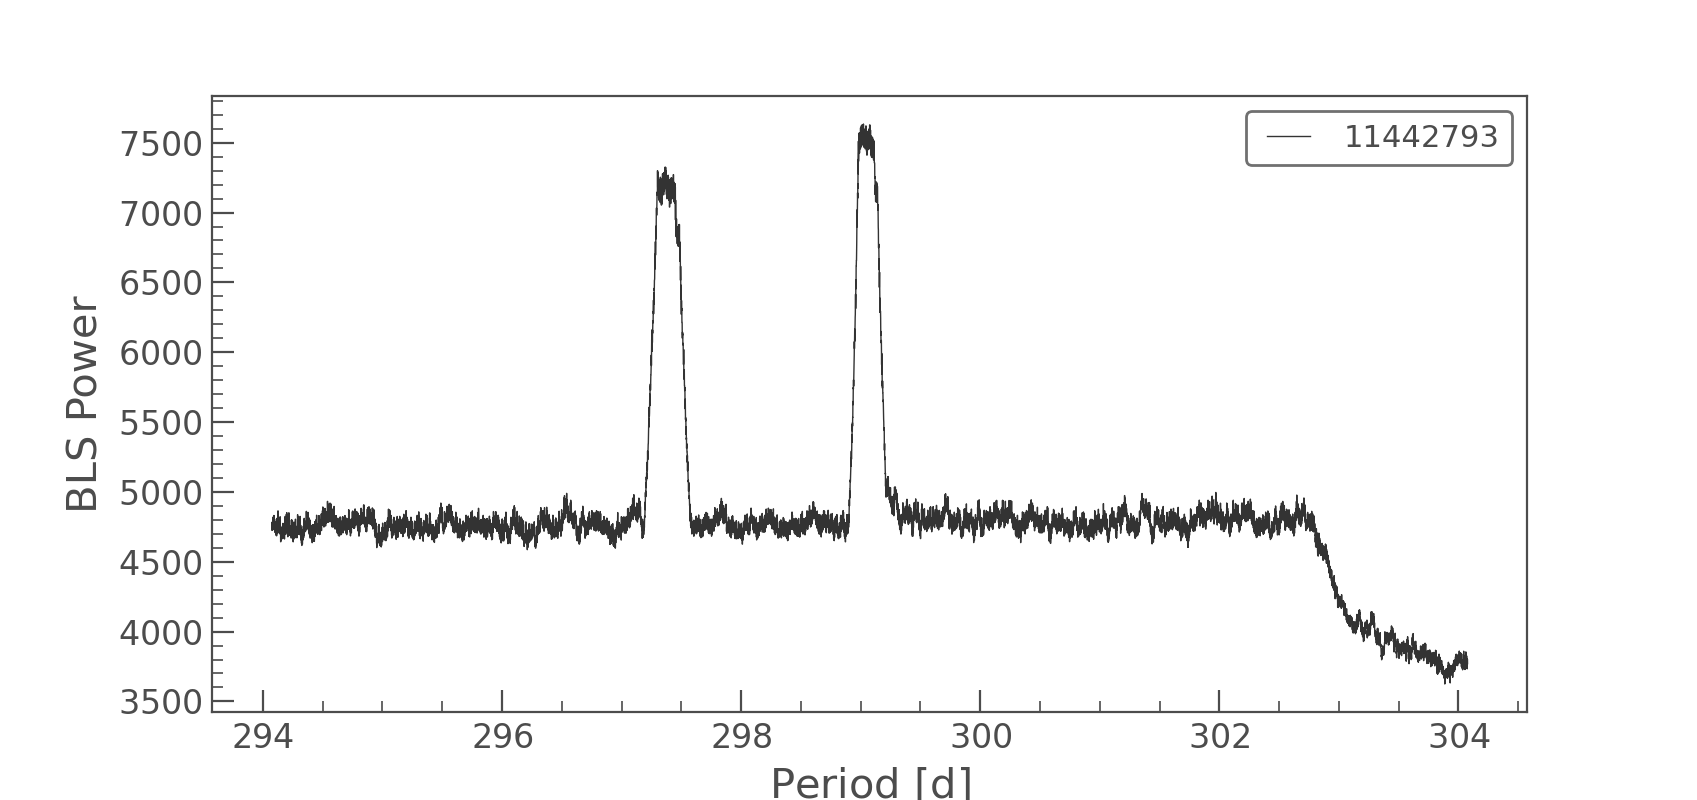

In [19]:
bls3.plot();

<IPython.core.display.Javascript object>


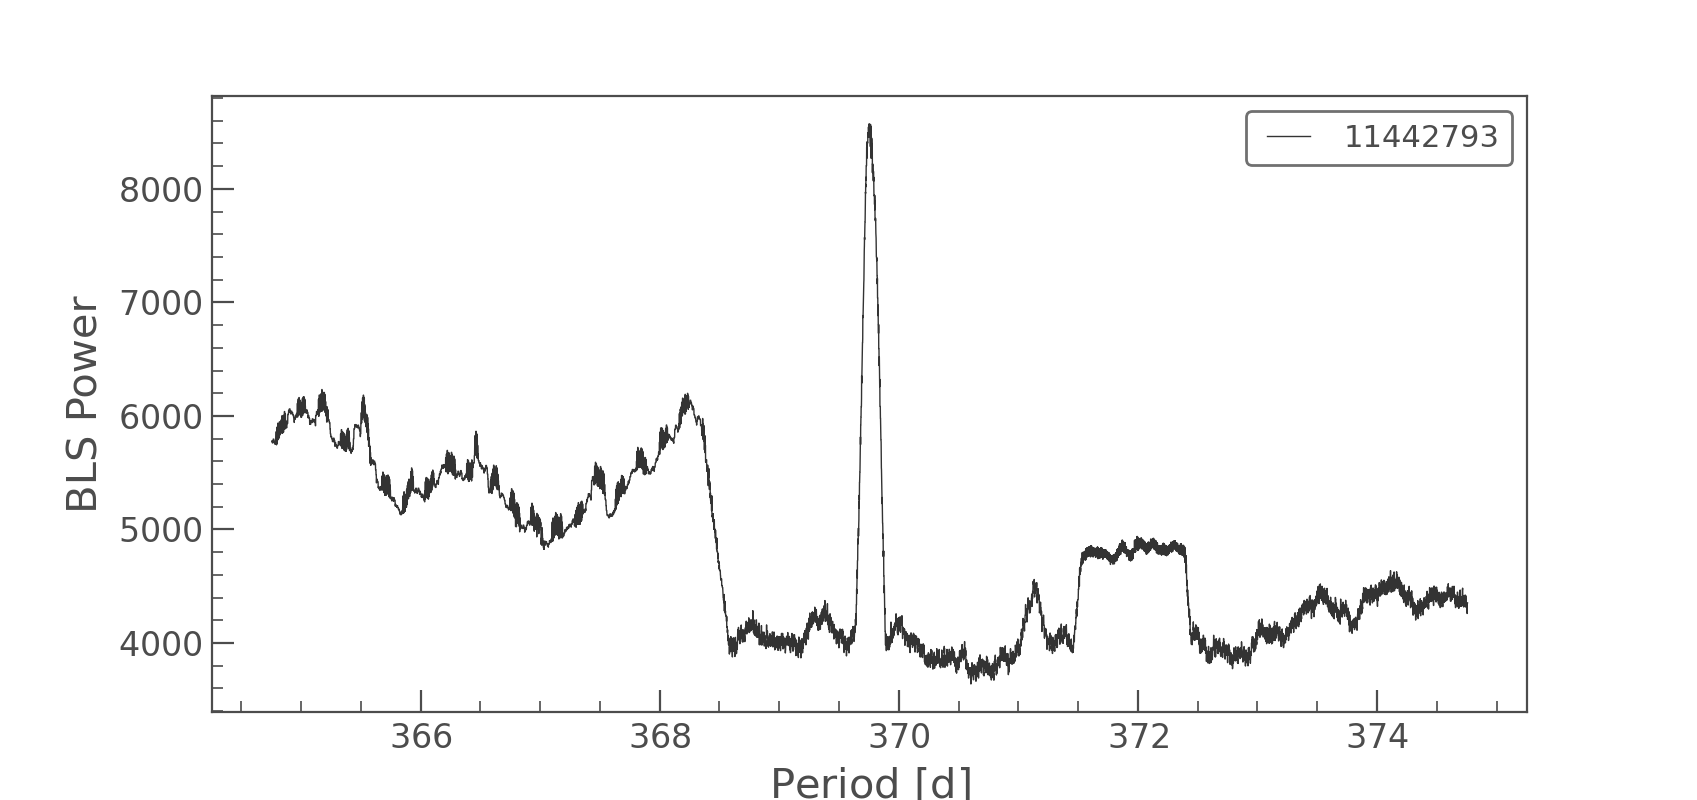

In [20]:
bls4.plot();

In [21]:
peak_refinedperiod1 = bls1.period[np.where(bls1.power == np.max(bls1.power))[0][0]]
peak_refinedperiod2 = bls2.period[np.where(bls2.power == np.max(bls2.power))[0][0]]
peak_refinedperiod3 = bls3.period[np.where(bls3.power == np.max(bls3.power))[0][0]]
peak_refinedperiod4 = bls4.period[np.where(bls4.power == np.max(bls4.power))[0][0]]

In [22]:
transittime1 = bls1.transit_time[np.where(bls1.power == np.max(bls1.power))[0][0]]
transittime2 = bls2.transit_time[np.where(bls2.power == np.max(bls2.power))[0][0]]
transittime3 = bls3.transit_time[np.where(bls3.power == np.max(bls3.power))[0][0]]
transittime4 = bls4.transit_time[np.where(bls4.power == np.max(bls4.power))[0][0]]

In [23]:
print('The periods with maximum power in the refined grids are:')
print(peak_refinedperiod1)
print(peak_refinedperiod2)
print(peak_refinedperiod3)
print(peak_refinedperiod4)

print('\n \n with transit times:')
print(transittime1)
print(transittime2)
print(transittime3)
print(transittime4)

The periods with maximum power in the refined grids are:
82.89323115515623 d
199.32181814594713 d
299.02302976136417 d
369.7536053634253 d

 
 with transit times:
140.54264779216805
140.54264779216805
140.54264779216805
357.56264779216804


# Q4. Use lightkurve.fold to plot the folded light curve for each of the best periods in Q3. (25 pts)

Full folded light curve for period of 82.9 days:

<IPython.core.display.Javascript object>


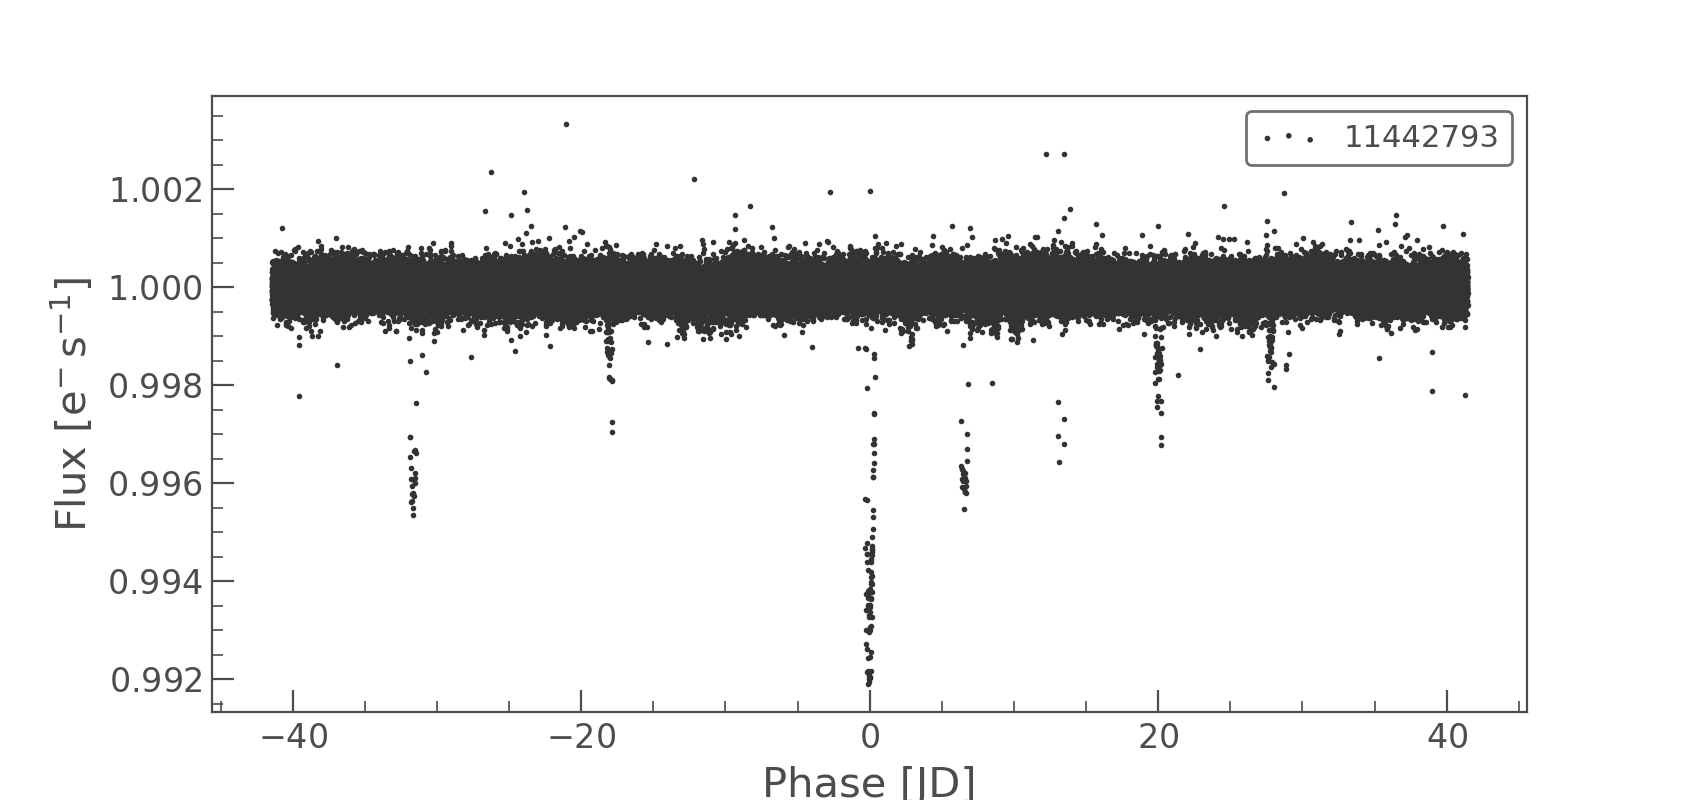

In [34]:
# YOUR CODE HERE
clc_read.fold(peak_refinedperiod1, transittime1).scatter();

Zoom-in to (-1, +1) days around phase = 0:

<IPython.core.display.Javascript object>


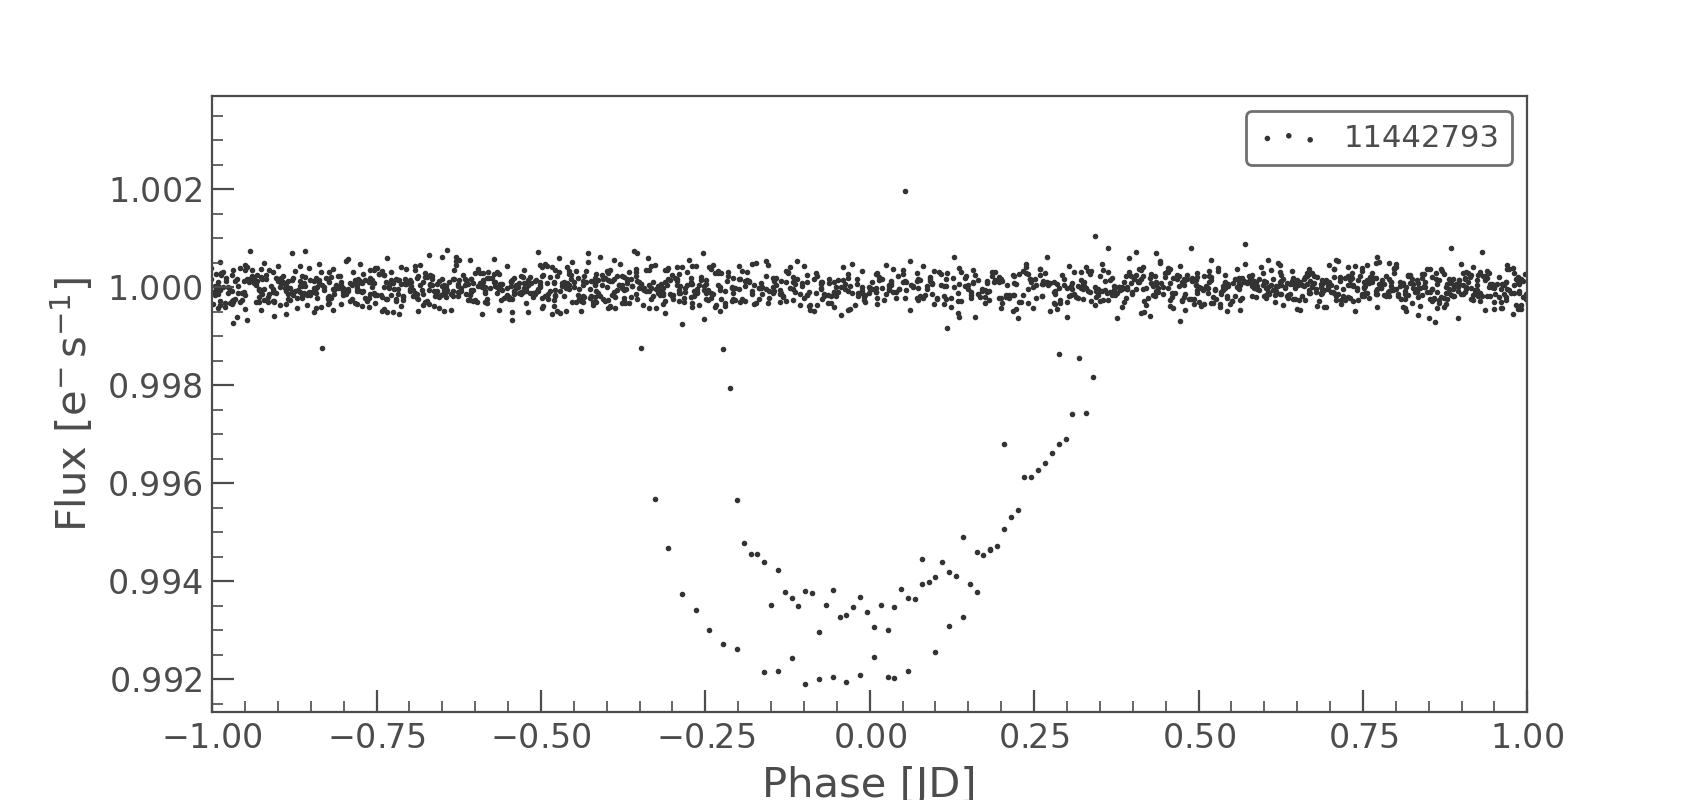

In [38]:
clc_read.fold(peak_refinedperiod1, transittime1).scatter();
xlim(-1, 1);

Full folded light curve for period of 199.32 d

<IPython.core.display.Javascript object>


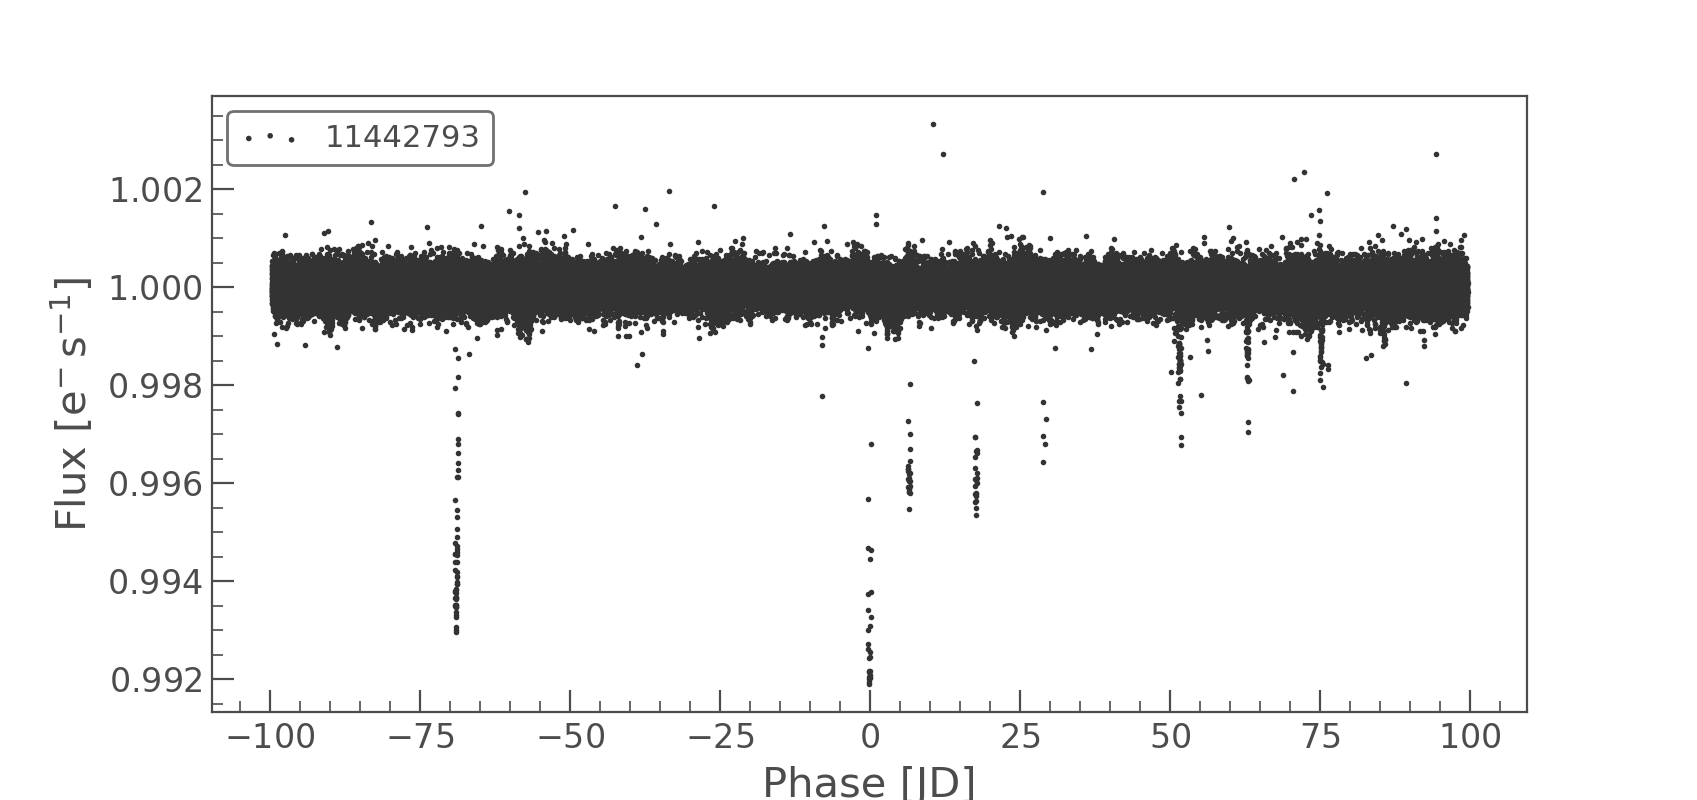

In [35]:
clc_read.fold(peak_refinedperiod2, transittime2).scatter();

Zoom-in to (-1, +1) days around phase = 0:

<IPython.core.display.Javascript object>


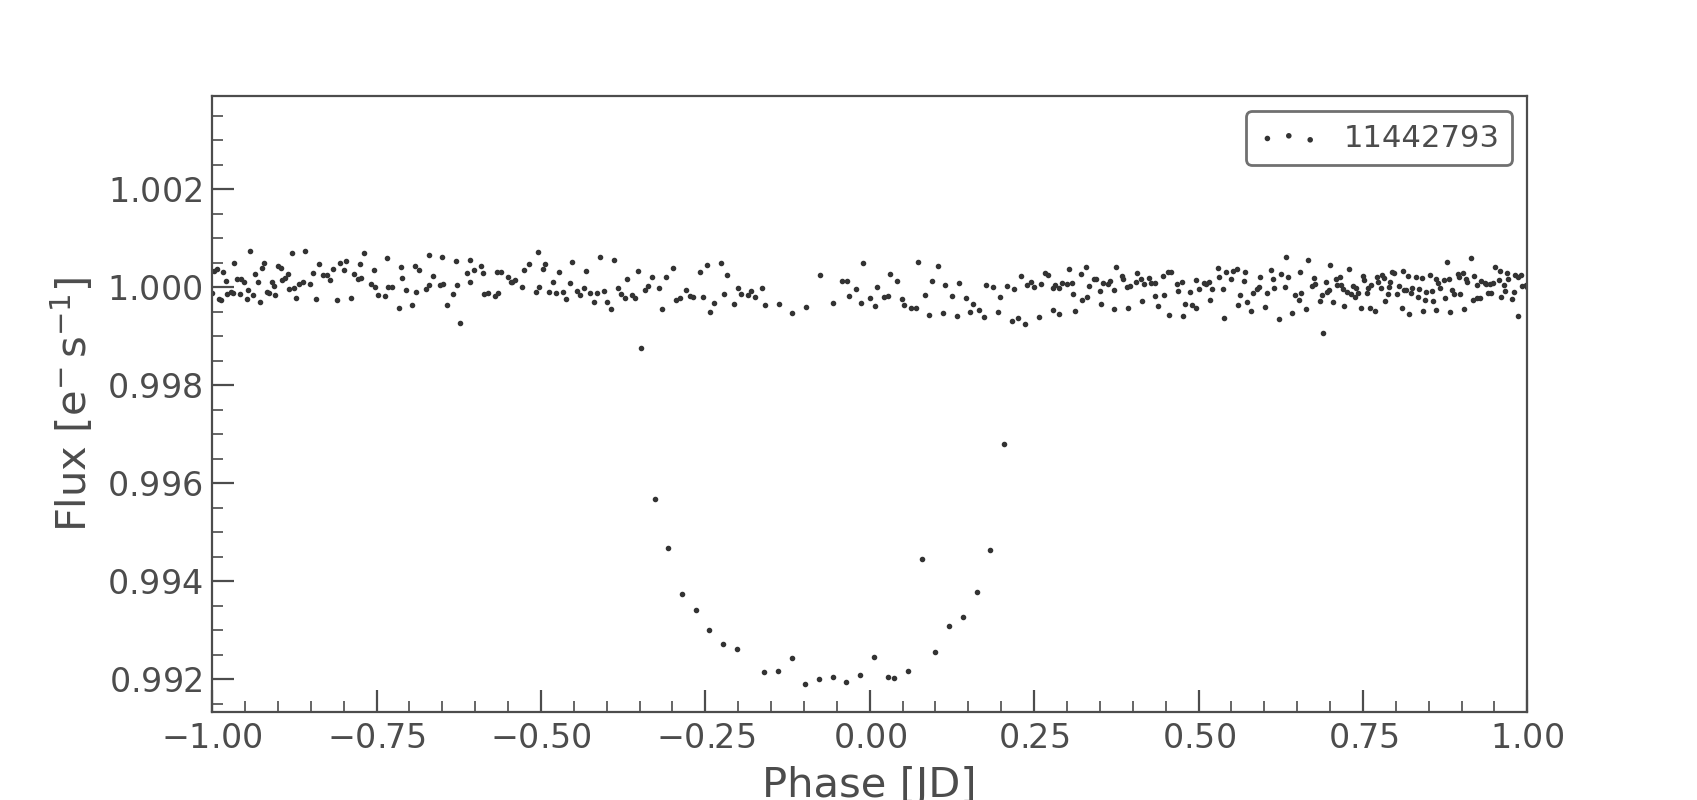

In [39]:
clc_read.fold(peak_refinedperiod2, transittime2).scatter();
xlim(-1, 1);

Full folded light curve for period of 299.02 d

<IPython.core.display.Javascript object>


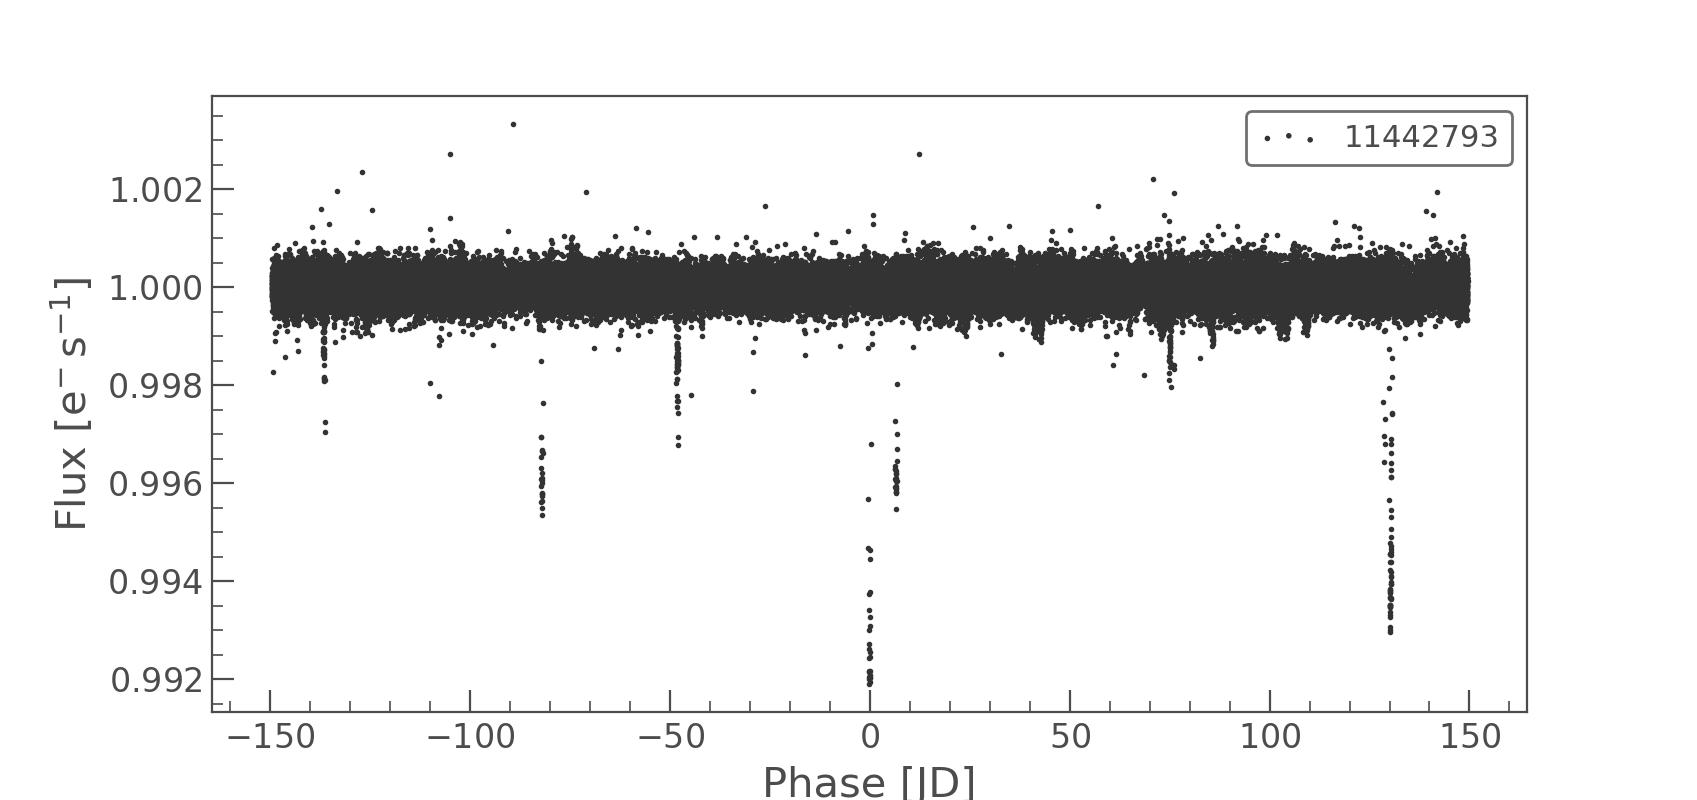

In [40]:
clc_read.fold(peak_refinedperiod3, transittime3).scatter();

Zoom-in to (-1, +1) days around phase = 0:

<IPython.core.display.Javascript object>


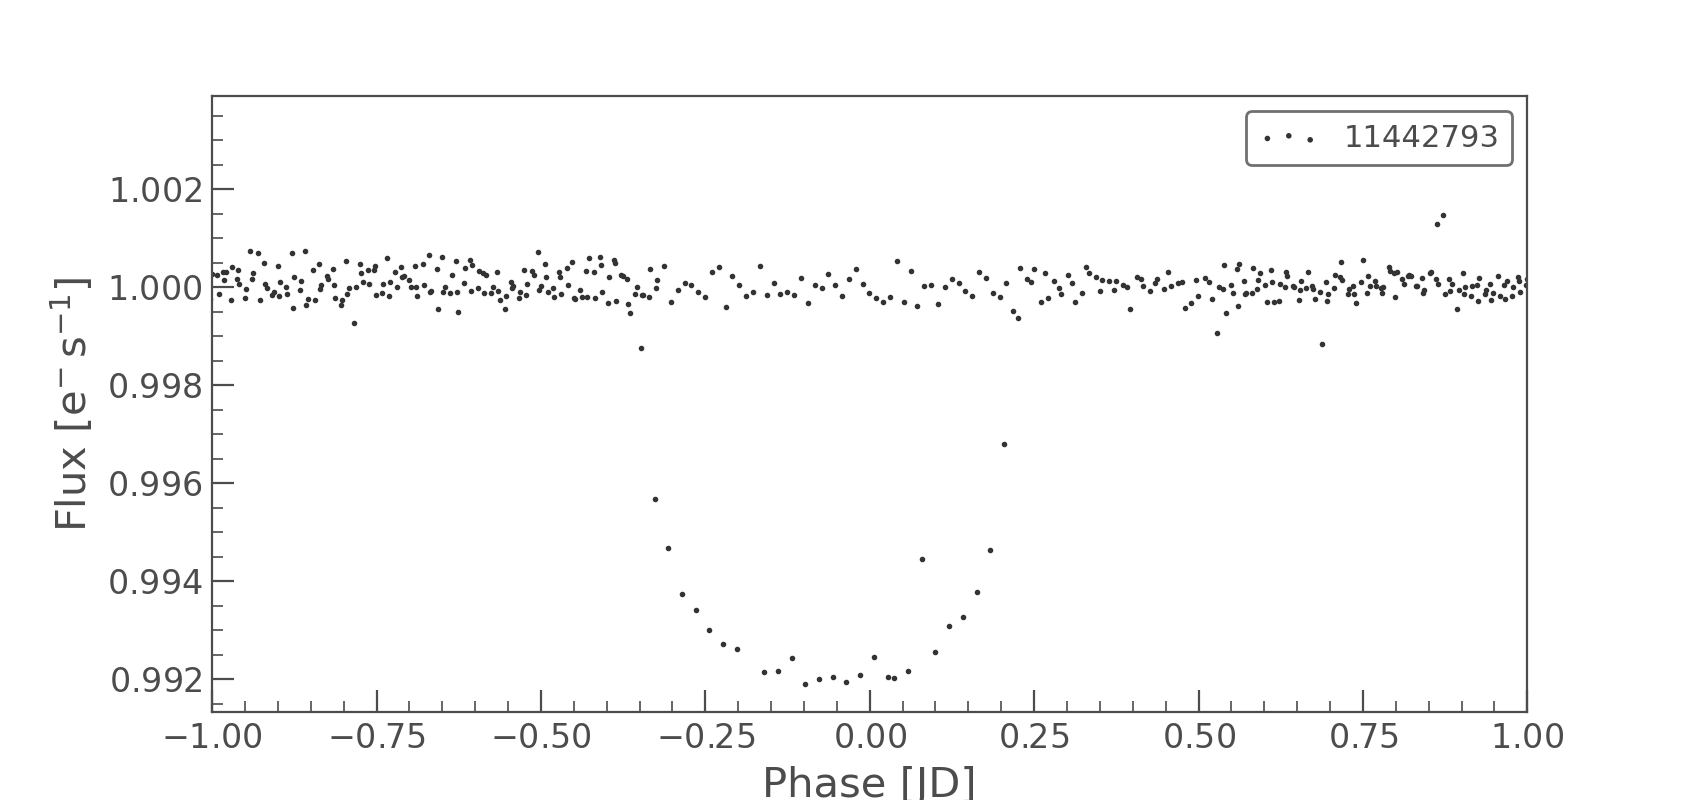

In [41]:
clc_read.fold(peak_refinedperiod3, transittime3).scatter();
xlim(-1, 1);

Full folded light curve for period of 369.75 d

<IPython.core.display.Javascript object>


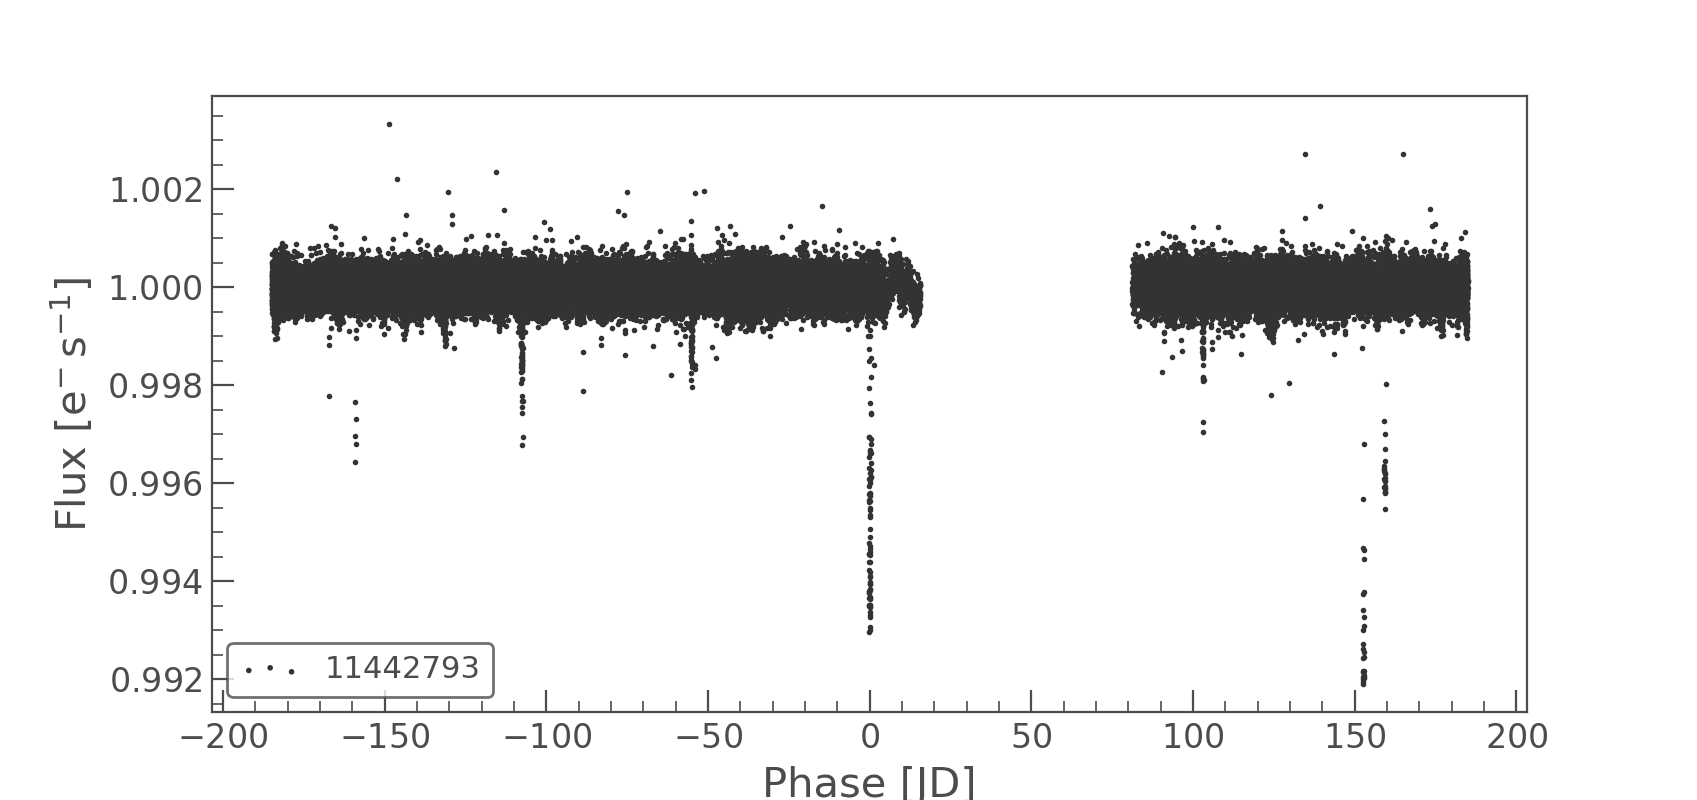

In [42]:
clc_read.fold(peak_refinedperiod4, transittime4).scatter();

Zoom-in to (-1, +1) days around phase = 0:

<IPython.core.display.Javascript object>


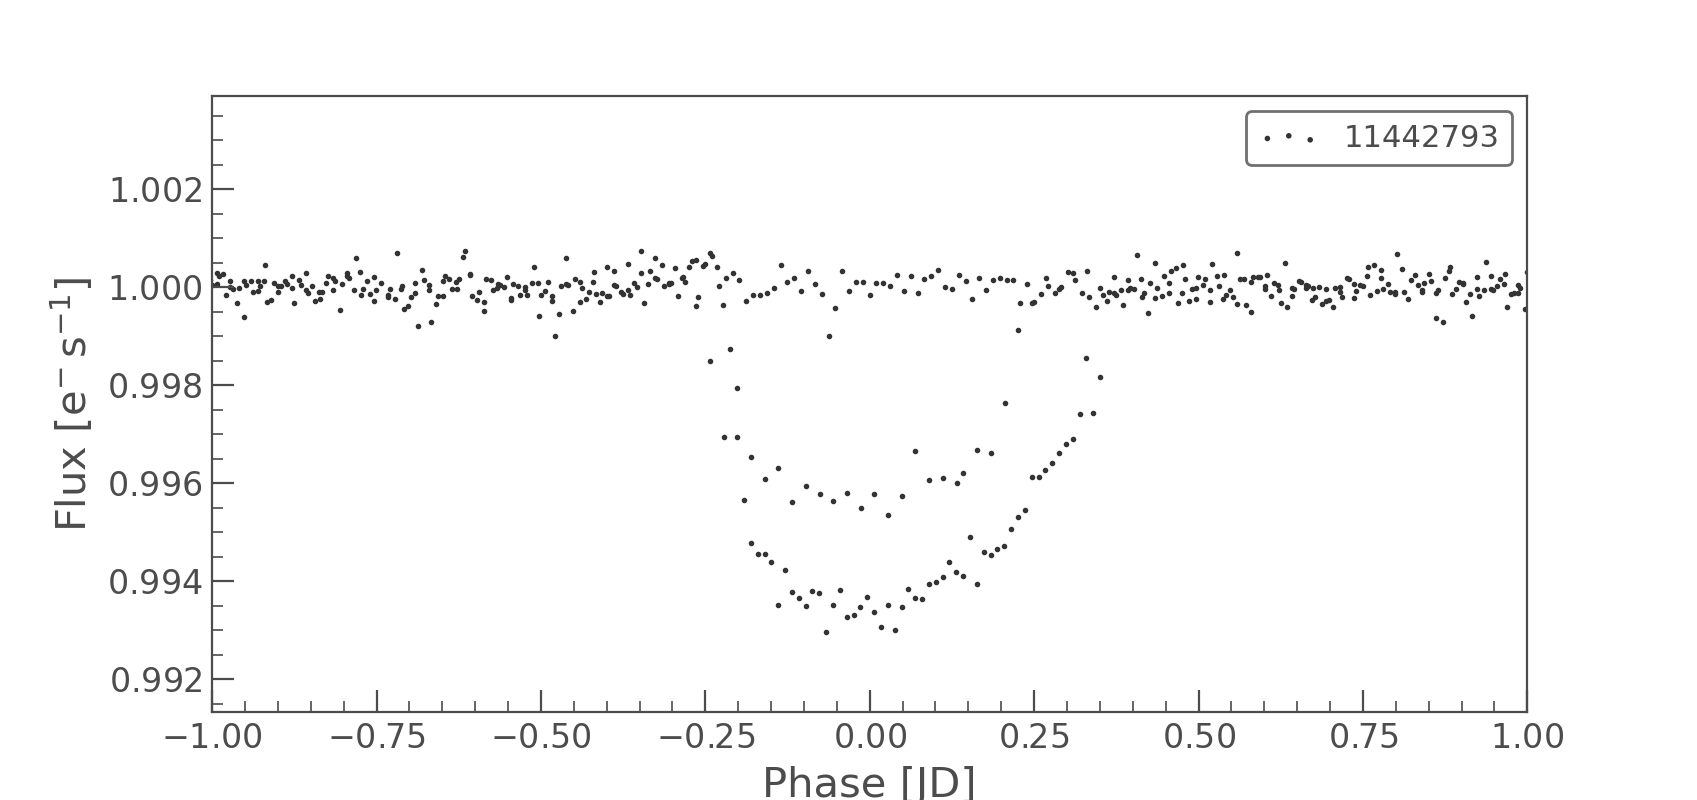

In [43]:
clc_read.fold(peak_refinedperiod4, transittime4).scatter();
xlim(-1, 1);

All of these folded light curves look pretty nice, although the fact that there is still some non-transit signals around phase = 0 may indicate that we are still folding at a multiple of the transit period instead of the true transit period. From the NASA Exoplanet Archive, Kepler-90 has 8 exoplanets, with the following periods in days:

| Planet | Period [d] | Reference|
|--------|------------|-----------|
|b|7.008151$\pm$0.000019 |Cabrera et al. 2014|
|c|8.719375$\pm$0.000027 | " |
|i|14.44912$\pm$0.00020 |Shallue & Vanderburg 2018|
|d| 59.73667$\pm$0.00038 |Cabrera et al. 2014|
|e| 91.93913$\pm$0.00073 |"|
|f| 124.9144$\pm$0.0019 |"|
|g| 210.60697$\pm$0.00043 |"|
|h| 331.60059$\pm$0.00037 |"|

I found:

In [44]:
print(peak_refinedperiod1)
print(peak_refinedperiod2)
print(peak_refinedperiod3)
print(peak_refinedperiod4)

82.89323115515623 d
199.32181814594713 d
299.02302976136417 d
369.7536053634253 d


Just as a sanity, check, we can look at the Cabrera et al. 2014 solution for the period of Kepler-90f

In [45]:
period_refinedf = np.linspace(124.9-5., 124.9+5., n_gridpoints_refined)

# calculate the bls (Box Least Squares) periodogram
blsf = clc_read.to_periodogram(method='bls', period=period_refinedf);

<IPython.core.display.Javascript object>


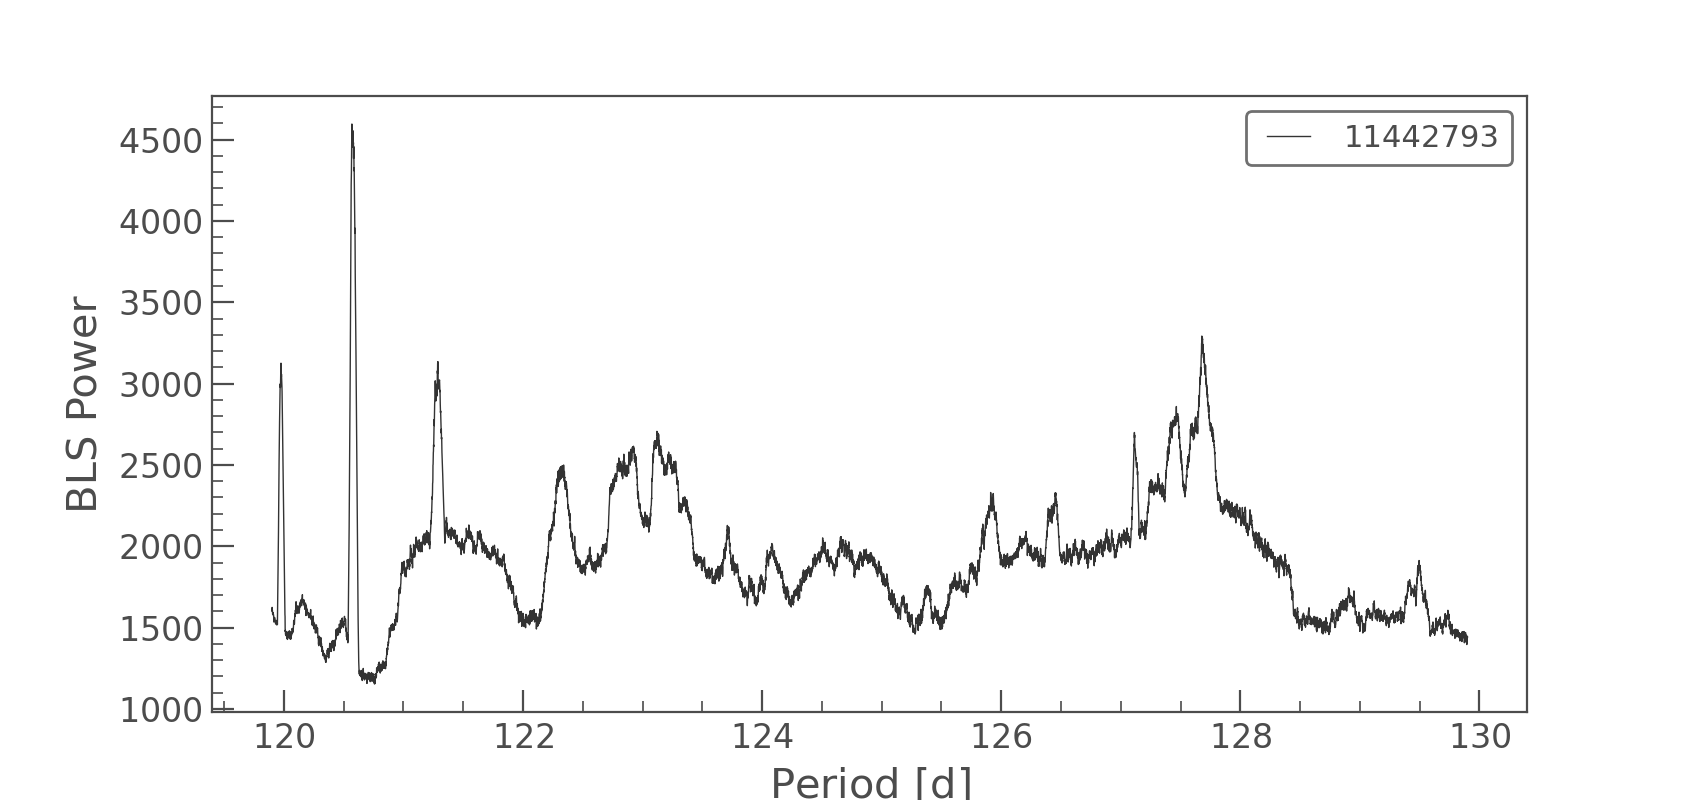

In [46]:
blsf.plot();

In [47]:
peak_refinedperiod_f = blsf.period[np.where(blsf.power == np.max(blsf.power))[0][0]]
transittime_f = blsf.transit_time[np.where(blsf.power == np.max(blsf.power))[0][0]]

<IPython.core.display.Javascript object>


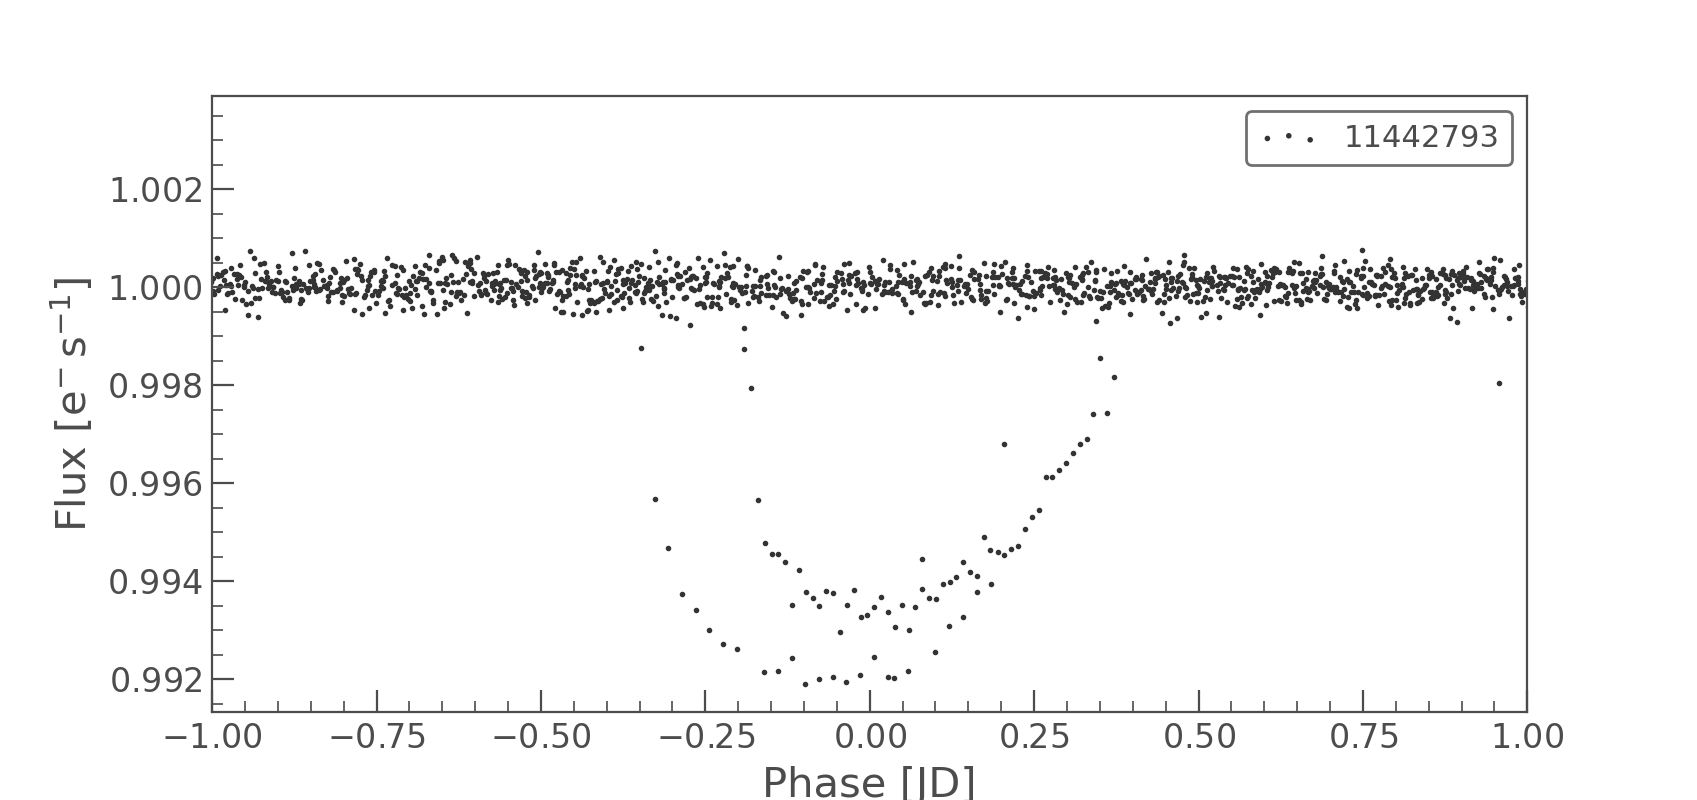

In [48]:
clc_read.fold(peak_refinedperiod_f, transittime_f).scatter();
xlim(-1, 1);

Even when we refine over the period where published results indicate an exoplanet is transiting, we're still getting these Flux = 1 values during the transit on the folded light curve. The periods I picked out from the peak power of the BLS at least now seem more reasonable.